# MLflow、AutoMLによるモデルアンサンブル

### 前提条件
* Databricks Runtime 8.3 ML以降(9.1 MLで動作確認)

##### 仮説
* アンサンブルはよりロバストで優れたパフォーマンスを達成するものですが、構築、維持が困難なものです。しかし、AutoMLがユーザーからその重荷を取り除きます。
* AutoMLはベストモデルを示すだけでなく、トレーニングされた全てのモデルのサマリーを提供します。
* これによって、ユーザーは単一のモデルよりアンサンブルモデルが優れているかどうかを容易に確認できる様になります。
* 全てのモデルのラン(トレーニング)が記録されているので、特にこのオプションを検証することが容易となります。

##### データセット
* このサンプルでは、Kaggleで提供されている[telco dataset](https://www.kaggle.com/blastchar/telco-customer-churn)を用いて、潜在的な顧客離脱を予測します。

## データ準備

事前に上記リンク先からCSVファイルをダウンロードし、上のメニューの**File > Upload Data**でDBFSにCSVファイルをアップロードしてください。

In [0]:
import re
from pyspark.sql.types import * 

# Username を取得
username_raw = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
# Username の英数字以外を除去し、全て小文字化。Username をファイルパスやデータベース名の一部で使用可能にするため。
username = re.sub('[^A-Za-z0-9]+', '', username_raw).lower()

print("username:", username)

username: takaakiyayoidatabrickscom

In [0]:
# 生データのロード
input_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/takaaki.yayoi@databricks.com/WA_Fn_UseC__Telco_Customer_Churn.csv")

# トレーニングデータセット・テストデータセットの分割
train_df, test_df = input_df.randomSplit([0.90, 0.1], seed=42)

#　new_dfは推論テストで使用します
new_df = test_df 
display(train_df)

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3,No
0003-MKNFE,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4,No
0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,Yes
0011-IGKFF,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98,1237.85,Yes
0013-EXCHZ,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4,Yes
0013-MHZWF,Female,0,No,Yes,9,Yes,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),69.4,571.45,No
0014-BMAQU,Male,0,Yes,No,63,Yes,Yes,Fiber optic,Yes,No,No,Yes,No,No,Two year,Yes,Credit card (automatic),84.65,5377.8,No
0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,90.45,5957.9,No
0017-DINOC,Male,0,No,No,54,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,Two year,No,Credit card (automatic),45.2,2460.55,No
0017-IUDMW,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),116.8,8456.75,No


### エンコーディング(文字列のchurnを数値に)

In [0]:
from pyspark.sql.functions import when, col
test_df = test_df.withColumn("churn", when(test_df.Churn == 'Yes' ,1).otherwise(0))
train_df = train_df.withColumn("churn", when(train_df.Churn == 'Yes' ,1).otherwise(0))

### ノートブックの後半でテストするために予測値を削除

In [0]:
import sklearn.metrics
import numpy as np
test_pdf = test_df.toPandas()
y_test = test_pdf["churn"]
X_test = test_pdf.drop("churn", axis=1)

## トレーニング

ターゲットカラムとトレーニング時間に関する停止条件を指定して、AutoMLによるモデルのトレーニングを実施します。

In [0]:
import databricks.automl

# データ出力先
data_dir = f"dbfs:/tmp/{username}/ensemble_automl/"
dbutils.fs.rm(data_dir, True)

Out[5]: True

In [0]:
automl_models = databricks.automl.classify(train_df, 
                                   target_col = "churn",
                                   data_dir= data_dir,
                                   timeout_minutes=60, 
                                   max_trials=1000) 

Columns ['MonthlyCharges', 'TotalCharges'] were detected to have semantic type numeric and will be automatically converted in the data exploration and training notebooks.
To see analysis of your data while training completes, open the data exploration notebook here:
https://e2-demo-west.cloud.databricks.com/?o=2556758628403379#notebook/2624478433034863

**********************************************************************************************************
Trials for training a model on the dataset have been kicked off. The model will be optimized
for the F1 score metric (tracked as val_f1_score in MLflow experiments).

You can track the completed trials in the MLflow experiment here:
https://e2-demo-west.cloud.databricks.com/?o=2556758628403379#mlflow/experiments/2624478433034862/s?orderByKey=metrics.%60val_f1_score%60&orderByAsc=false

Notebooks that generate the trials can be edited to tweak the setup, add hyperparameters and re-run the trials.
All re-run notebooks will log the trials under the same experiment.
Generated notebooks contain instructions to load models from your favorite trials.
**********************************************************************************************************

 0%| | 0/1000 [00:00<?, ?trial/s, best loss=?] 0%| | 1/1000 [00:26<7:16:56, 26.24s/trial, best loss: -0.6837457544301356] 0%| | 2/1000 [00:27<3:09:33, 11.40s/trial, best loss: -0.7853358623153394] 0%| | 3/1000 [00:28<1:50:32, 6.65s/trial, best loss: -0.7853358623153394] 0%| | 5/1000 [00:31<1:02:02, 3.74s/trial, best loss: -0.7853358623153394] 1%| | 8/1000 [00:51<1:28:49, 5.37s/trial, best loss: -0.7853358623153394] 1%| | 9/1000 [00:54<1:20:41, 4.89s/trial, best loss: -0.7853358623153394] 1%| | 10/1000 [00:56<1:09:47, 4.23s/trial, best loss: -0.7853358623153394] 1%| | 11/1000 [00:57<56:39, 3.44s/trial, best loss: -0.7939166244725618]  1%| | 12/1000 [01:21<2:25:17, 8.82s/trial, best loss: -0.7939166244725618] 1%|▏ | 13/1000 [01:23<1:54:47, 6.98s/trial, best loss: -0.7939166244725618] 1%|▏ | 14/1000 [01:27<1:41:08, 6.15s/trial, best loss: -0.7939166244725618] 2%|▏ | 15/1000 [02:09<4:29:35, 16.42s/trial, best loss: -0.7939166244725618] 2%|▏ | 16/1000 [02:15<3:39:55, 13.41s/trial, best loss: -0.7939166244725618] 2%|▏ | 17/1000 [02:16<2:40:15, 9.78s/trial, best loss: -0.7939166244725618] 2%|▏ | 18/1000 [02:19<2:07:26, 7.79s/trial, best loss: -0.7939166244725618] 2%|▏ | 19/1000 [02:27<2:08:25, 7.85s/trial, best loss: -0.7939166244725618] 2%|▏ | 20/1000 [02:31<1:49:37, 6.71s/trial, best loss: -0.7939166244725618] 2%|▏ | 21/1000 [02:38<1:50:57, 6.80s/trial, best loss: -0.7939166244725618] 2%|▏ | 22/1000 [02:39<1:22:39, 5.07s/trial, best loss: -0.7939166244725618] 2%|▏ | 23/1000 [02:45<1:27:08, 5.35s/trial, best loss: -0.7939166244725618] 2%|▏ | 24/1000 [02:48<1:15:39, 4.65s/trial, best loss: -0.7939166244725618] 2%|▎ | 25/1000 [03:04<2:10:55, 8.06s/trial, best loss: -0.7939166244725618] 3%|▎ | 27/1000 [03:09<1:29:07, 5.50s/trial, best loss: -0.7939166244725618] 3%|▎ | 28/1000 [03:17<1:39:09, 6.12s/trial, best loss: -0.7939166244725618] 3%|▎ | 29/1000 [03:29<1:59:47, 7.40s/trial, best loss: -0.7939166244725618] 3%|▎ | 30/1000 [03:32<1:40:22, 6.21s/trial, best loss: -0.7939166244725618] 3%|▎ | 31/1000 [03:33<1:16:44, 4.75s/trial, best loss: -0.7939166244725618] 3%|▎ | 32/1000 [03:37<1:13:15, 4.54s/trial, best loss: -0.7939166244725618] 3%|▎ | 33/1000 [03:40<1:06:01, 4.10s/trial, best loss: -0.7939166244725618] 3%|▎ | 34/1000 [03:45<1:10:17, 4.37s/trial, best loss: -0.7939166244725618] 4%|▎ | 35/1000 [03:52<1:22:46, 5.15s/trial, best loss: -0.7939166244725618] 4%|▍ | 38/1000 [03:57<51:23, 3.21s/trial, best loss: -0.7939166244725618]  4%|▍ | 39/1000 [04:03<1:00:48, 3.80s/trial, best loss: -0.7939166244725618] 4%|▍ | 40/1000 [04:13<1:23:45, 5.23s/trial, best loss: -0.7939166244725618] 4%|▍ | 41/1000 [04:17<1:18:48, 4.93s/trial, best loss: -0.7939166244725618] 4%|▍ | 42/1000 [04:20<1:10:42, 4.43s/trial, be

,Validation,Train
f1_score,0.798,0.804
score,0.807,0.811
recall_score,0.807,0.811
accuracy_score,0.807,0.811
log_loss,0.419,0.400
precision_score,0.797,0.802
roc_auc_score,0.841,0.857


In [0]:
automl_models

Out[7]: <databricks.automl.result.AutoMLSummary at 0x7fad83f61940>

### Experiment IDの取得

In [0]:
import mlflow
from mlflow.tracking.client import MlflowClient

client = MlflowClient()
experiment_id = automl_models.experiment.experiment_id
experiment_id

Out[8]: '2624478433034862'

### ベストモデルの特定

In [0]:
print(automl_models.best_trial.model_description)
best_model_uri = automl_models.best_trial.model_path
metrics = automl_models.best_trial.metrics
print('accuracy=', metrics['val_accuracy_score'], ' f1 score=', metrics['val_f1_score'], ' precision=', metrics['val_precision_score'],  \
                ' recall=',metrics['val_recall_score'],  ' roc_auc_score=',metrics['val_roc_auc_score'])
predict_udf = mlflow.pyfunc.spark_udf(spark, model_uri=best_model_uri, result_type="integer")
test_df = test_df.withColumn("bestModel", predict_udf())
display(test_df)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
 colsample_bynode=None, colsample_bytree=None, gamma=None,
 gpu_id=None, importance_type='gain', interaction_constraints=None,
 learning_ra...
accuracy= 0.807061790668348 f1 score= 0.7980211068157858 precision= 0.7966256401215728 recall= 0.807061790668348 roc_auc_score= 0.8411274474499191

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,bestModel
0013-SMEOE,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.7,7904.25,0,0
0015-UOCOJ,Female,1,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,48.2,340.35,0,0
0080-OROZO,Female,0,No,No,35,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,99.25,3532,0,0
0096-BXERS,Female,0,Yes,No,6,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,50.35,314.55,0,0
0125-LZQXK,Male,0,No,No,15,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,101.35,1553.95,1,1
0178-CIIKR,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.95,58,0,0
0203-HHYIJ,Male,0,No,No,25,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),25.3,676.35,1,0
0206-OYVOC,Female,0,Yes,Yes,46,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,19.25,864.2,0,0
0221-WMXNQ,Male,1,No,No,4,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Electronic check,75.35,273.4,0,1
0260-ZDLGK,Female,0,No,Yes,9,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Mailed check,72.9,651.4,1,0


### ベストモデルに対するコンフュージョンマトリクスの取得

Out[10]:

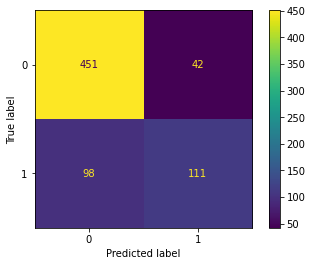

<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fad8098da00>

In [0]:
model = mlflow.sklearn.load_model(best_model_uri)
sklearn.metrics.plot_confusion_matrix(model, X_test, y_test)

### エクスペリメントのランにおける全ての異なるアーキテクチャからトップモデルを特定

#### F1スコアに基づき異なるアーキテクチャでのベストモデルに対するコンフュージョンマトリクスを生成

params.classifier LIKE 'DecisionTree%'
accuracy= 0.7906683480453972 f1 score= 0.7871264250797826 precision= 0.7847227929214095 recall= 0.7906683480453972 roc_auc_score= 0.8244904468428798
params.classifier LIKE 'LogisticRegression%'
accuracy= 0.766078184110971 f1 score= 0.7592988082139179 precision= 0.7553909934301467 recall= 0.766078184110971 roc_auc_score= 0.7729178027224183
params.classifier LIKE 'RandomForest%'
accuracy= 0.798234552332913 f1 score= 0.7811849638368984 precision= 0.7847345134829539 recall= 0.798234552332913 roc_auc_score= 0.8367989464261829
params.classifier LIKE 'LGBM%'
accuracy= 0.8026481715006305 f1 score= 0.7918796323275742 precision= 0.790969359870167 recall= 0.8026481715006305 roc_auc_score= 0.8407158951776362
params.classifier LIKE 'XGB%'
accuracy= 0.807061790668348 f1 score= 0.7980211068157858 precision= 0.7966256401215728 recall= 0.807061790668348 roc_auc_score= 0.8411274474499191

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,bestModel,DecisionTree,LogisticRegression,RandomForest,LGBM,XGB
0013-SMEOE,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.7,7904.25,0,0,0,0,0,0,0
0015-UOCOJ,Female,1,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,48.2,340.35,0,0,1,0,0,0,0
0080-OROZO,Female,0,No,No,35,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,99.25,3532,0,0,0,0,0,0,0
0096-BXERS,Female,0,Yes,No,6,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,50.35,314.55,0,0,1,0,0,0,0
0125-LZQXK,Male,0,No,No,15,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,101.35,1553.95,1,1,1,0,0,1,1
0178-CIIKR,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.95,58,0,0,0,0,0,0,0
0203-HHYIJ,Male,0,No,No,25,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),25.3,676.35,1,0,0,0,0,0,0
0206-OYVOC,Female,0,Yes,Yes,46,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,19.25,864.2,0,0,0,0,0,0,0
0221-WMXNQ,Male,1,No,No,4,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Electronic check,75.35,273.4,0,1,0,0,0,0,1
0260-ZDLGK,Female,0,No,Yes,9,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Mailed check,72.9,651.4,1,0,0,0,0,0,0


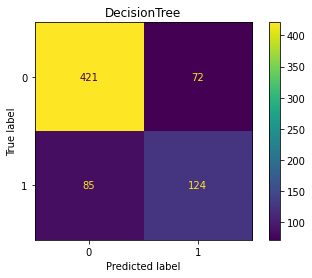

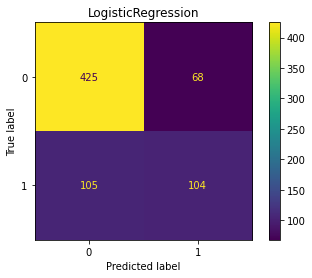

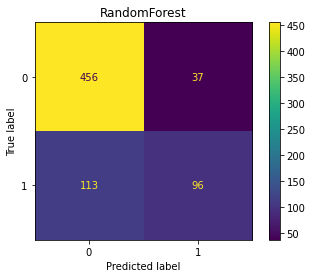

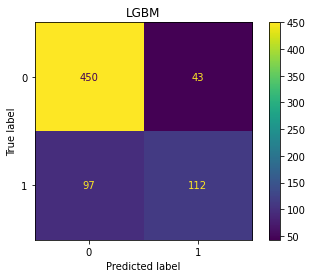

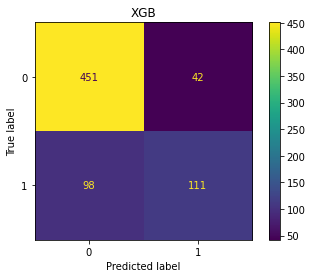

In [0]:
model_types = ['DecisionTree', 'LogisticRegression', 'RandomForest', 'LGBM', 'XGB']
for model_type in model_types:
  filter_str = "params.classifier LIKE '" + model_type + "%'"
  print(filter_str)
  
  models = (client.search_runs(experiment_ids=experiment_id, filter_string=filter_str, order_by=["metrics.val_f1_score DESC"]))
  
  
  if models:
    model = models[0]
    metrics = model.data.metrics
    print('accuracy=', metrics['val_accuracy_score'], ' f1 score=', metrics['val_f1_score'], ' precision=', metrics['val_precision_score'],  \
                ' recall=',metrics['val_recall_score'],  ' roc_auc_score=',metrics['val_roc_auc_score'])
    best_runId = model.info.run_uuid
    model_uri = f"runs:/{best_runId}/model"

    predict_udf = mlflow.pyfunc.spark_udf(spark, model_uri=model_uri, result_type="integer")
    test_df = test_df.withColumn(model_type, predict_udf())
    
    model = mlflow.sklearn.load_model(model_uri)  
    disp = sklearn.metrics.plot_confusion_matrix(model, X_test, y_test)
    disp.ax_.set_title(model_type)

display(test_df)

### アンサンブルのオプション

#### いくつのモデル？

##### 投票戦略

* 多数決？
* 75%以上？
* 組み合わせ？

### バイアスと個々のモデルのエラーを削減するための個々のモデルによる投票

In [0]:
@udf('integer')
def ensembleAll(decision_tree, logistic_regression, random_forest, light_gbm, xgboost):
  votes = decision_tree +logistic_regression + random_forest + light_gbm + xgboost
  if votes >= 4:
    return 1
  else:
    return 0

@udf('integer')
def ensembleTop4(decision_tree, random_forest, light_gbm, xgboost):
  votes = decision_tree + random_forest + light_gbm + xgboost
  if votes >= 3:
    return 1
  else:
    return 0
  
@udf('integer')
def ensembleTop3(random_forest, light_gbm, xgboost):
  votes = random_forest + light_gbm + xgboost
  if votes >= 2:
    return 1
  else:
    return 0
  
@udf('integer')
def ensembleTop2(light_gbm, xgboost):
  votes = light_gbm + xgboost
  if votes >= 1:
    return 1
  else:
    return 0

### AutoMLのベストモデルと様々なアンサンブルの比較

#### アンサンブルのスコア

In [0]:
model_type='Ensemble'
test_df = test_df.withColumn('FullEnsemble', ensembleAll('DecisionTree','LogisticRegression','RandomForest','LGBM', 'XGB'))
test_df = test_df.withColumn('ensembleTop4', ensembleTop4('DecisionTree','RandomForest','LGBM', 'XGB'))
test_df = test_df.withColumn('ensembleTop3', ensembleTop3('RandomForest','LGBM', 'XGB'))
test_df = test_df.withColumn('ensembleTop2', ensembleTop2('LGBM', 'XGB'))
display(test_df)   

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,bestModel,DecisionTree,LogisticRegression,RandomForest,LGBM,XGB,FullEnsemble,ensembleTop4,ensembleTop3,ensembleTop2
0013-SMEOE,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.7,7904.25,0,0,0,0,0,0,0,0,0,0,0
0015-UOCOJ,Female,1,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,48.2,340.35,0,0,1,0,0,0,0,0,0,0,0
0080-OROZO,Female,0,No,No,35,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,99.25,3532,0,0,0,0,0,0,0,0,0,0,0
0096-BXERS,Female,0,Yes,No,6,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,50.35,314.55,0,0,1,0,0,0,0,0,0,0,0
0125-LZQXK,Male,0,No,No,15,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,101.35,1553.95,1,1,1,0,0,1,1,0,1,1,1
0178-CIIKR,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.95,58,0,0,0,0,0,0,0,0,0,0,0
0203-HHYIJ,Male,0,No,No,25,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),25.3,676.35,1,0,0,0,0,0,0,0,0,0,0
0206-OYVOC,Female,0,Yes,Yes,46,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,19.25,864.2,0,0,0,0,0,0,0,0,0,0,0
0221-WMXNQ,Male,1,No,No,4,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Electronic check,75.35,273.4,0,1,0,0,0,0,1,0,0,0,1
0260-ZDLGK,Female,0,No,Yes,9,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Mailed check,72.9,651.4,1,0,0,0,0,0,0,0,0,0,0


#### アンサンブルのメトリクス

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


def plotCM(y_pred, model_type):
  labels = [0,1]
  cm = confusion_matrix(y_test, y_pred, labels)
  print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title(model_type)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()
  print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
  print("Precision Score: ", precision_score(y_test, y_pred, average="macro"))
  print("Recall Score: ", recall_score(y_test, y_pred, average="macro")) 

#### ベストモデルと様々なアンサンブルのコンフュージョンマトリクスの生成

Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[[451 42]
 [ 98 111]]
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator

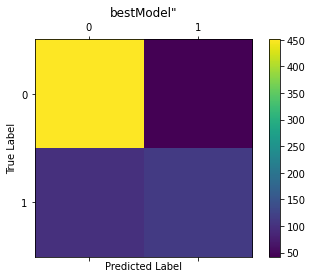

F1 Score: 0.7394513313750649
Precision Score: 0.7734919104253724
Recall Score: 0.7229538903500684
Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[[462 31]
 [113 96]]
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator

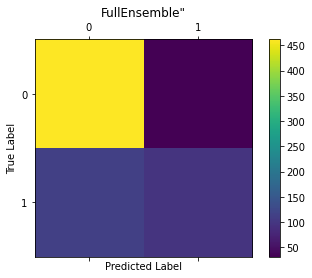

F1 Score: 0.718298555377207
Precision Score: 0.7796918863402944
Recall Score: 0.6982249094985297
Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[[457 36]
 [104 105]]
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator

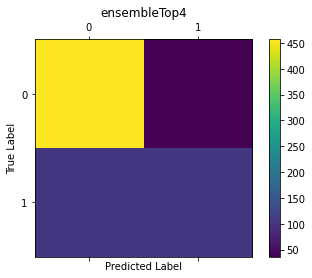

F1 Score: 0.7335863377609108
Precision Score: 0.779648803428528
Recall Score: 0.7146850160621911
Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[[453 40]
 [ 98 111]]
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator

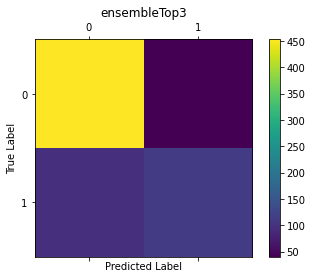

F1 Score: 0.7422413793103448
Precision Score: 0.7786204492734462
Recall Score: 0.7249822879159913
Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
[[444 49]
 [ 90 119]]
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator

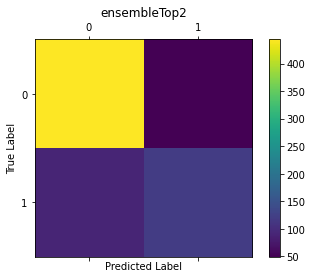

F1 Score: 0.7479770338783871
Precision Score: 0.7698970037453183
Recall Score: 0.7349932548501994

In [0]:
pdf = test_df.toPandas()

y_pred = pdf["bestModel"]
plotCM(y_pred, 'bestModel"')

y_pred = pdf["FullEnsemble"]
plotCM(y_pred, 'FullEnsemble"')

y_pred = pdf["ensembleTop4"]
plotCM(y_pred, 'ensembleTop4')

y_pred = pdf["ensembleTop3"]
plotCM(y_pred, 'ensembleTop3')

y_pred = pdf["ensembleTop2"]
plotCM(y_pred, 'ensembleTop2')

## MLFlow: アンサンブル管理のオプション

レジストリへのプロモーション

#### アンサンブルの最終的なモデルのリスト

In [0]:
model_types = ['DecisionTree', 'RandomForest', 'LGBM', 'XGB']

### オプション#1: それぞれのモデルを別々に記録

#### 1 - アンサンブルのモデルを別々にレジストリに記録し、ステージング/プロダクションにプロモーション

In [0]:
for model_type in model_types:
  filter_str = "params.classifier LIKE '" + model_type + "%'"
  model_name = model_type
  model = (client.search_runs(experiment_ids=experiment_id, filter_string=filter_str, order_by=["metrics.val_f1_score DESC"]))[0]
  best_runId = model.info.run_uuid
  model_uri = f"runs:/{best_runId}/model"
  model_details = mlflow.register_model(model_uri, model_name)

# モデルはステージング、プロダクションにプロモーションされる場合があります
model_stage = 'Production'
for model_name in model_types:
    client.transition_model_version_stage(model_name, 1, stage=model_stage)

Successfully registered model 'DecisionTree'.
2021/09/25 23:22:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTree, version 1
Created version '1' of model 'DecisionTree'.
Successfully registered model 'RandomForest'.
2021/09/25 23:22:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest, version 1
Created version '1' of model 'RandomForest'.
Successfully registered model 'LGBM'.
2021/09/25 23:22:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM, version 1
Created version '1' of model 'LGBM'.
Successfully registered model 'XGB'.
2021/09/25 23:22:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: XGB, version 1
Created version '1' of model 'XGB'.

#### 2 - 登録されている全てのモデルをロードし、予測のためにアンサンブルを使用

In [0]:
def ensemble_inference(df):
  from mlflow.tracking import MlflowClient
  client = mlflow.tracking.MlflowClient()
  
  # 4モデル全てをロード: プロダクションの最新モデル
  for model_name in model_types:
    model_version = client.get_latest_versions(model_name, stages=[model_stage])[0].version
    model_uri = "models:/{model_name}/{model_stage}".format(model_name=model_name, model_stage=model_stage)
    predict_udf = mlflow.pyfunc.spark_udf(spark, model_uri=model_uri, result_type="integer")
  
    # スコアリング
    df = df.withColumn(model_name, predict_udf())
  
  # udf
  ensemble_predict_df = df.withColumn('prediction', ensembleTop4('DecisionTree','RandomForest','LGBM', 'XGB'))
  display(ensemble_predict_df)
  return ensemble_predict_df

#### 3 - 新規データのスコアリング

In [0]:
ensemble_predict_df = ensemble_inference(new_df)

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,DecisionTree,RandomForest,LGBM,XGB,prediction
0013-SMEOE,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.7,7904.25,No,0,0,0,0,0
0015-UOCOJ,Female,1,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,48.2,340.35,No,1,0,0,0,0
0080-OROZO,Female,0,No,No,35,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,99.25,3532,No,0,0,0,0,0
0096-BXERS,Female,0,Yes,No,6,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,50.35,314.55,No,1,0,0,0,0
0125-LZQXK,Male,0,No,No,15,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,101.35,1553.95,Yes,1,0,1,1,1
0178-CIIKR,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.95,58,No,0,0,0,0,0
0203-HHYIJ,Male,0,No,No,25,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),25.3,676.35,Yes,0,0,0,0,0
0206-OYVOC,Female,0,Yes,Yes,46,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,19.25,864.2,No,0,0,0,0,0
0221-WMXNQ,Male,1,No,No,4,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Electronic check,75.35,273.4,No,0,0,0,1,0
0260-ZDLGK,Female,0,No,Yes,9,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Mailed check,72.9,651.4,Yes,0,0,0,0,0


### オプション#2: 単一のアンサンブルモデルを記録

##### アンサンブルを単一モデルと取り扱える様にpyfuncを使用
* モデルを登録
* アンサンブルを参照した推論
* https://databricks.com/notebooks/dff/01_dff_model.html

#### 1 - 個々のモデルをロード

In [0]:
filter_str = "params.classifier LIKE 'DecisionTree%'"
model = (client.search_runs(experiment_ids=experiment_id, filter_string=filter_str, order_by=["metrics.val_f1_score DESC"]))[0]
best_runId = model.info.run_uuid
DecisionTree_model_uri = f"runs:/{best_runId}/model"    
DecisionTree_model = mlflow.sklearn.load_model(DecisionTree_model_uri) 


filter_str = "params.classifier LIKE 'RandomForest%'"
model = (client.search_runs(experiment_ids=experiment_id, filter_string=filter_str, order_by=["metrics.val_f1_score DESC"]))[0]
best_runId = model.info.run_uuid
RandomForest_model_uri = f"runs:/{best_runId}/model"    
RandomForest_model = mlflow.sklearn.load_model(RandomForest_model_uri)  


filter_str = "params.classifier LIKE 'LGBM%'"
model = (client.search_runs(experiment_ids=experiment_id, filter_string=filter_str, order_by=["metrics.val_f1_score DESC"]))[0]
best_runId = model.info.run_uuid
LGBM_model_uri = f"runs:/{best_runId}/model"    
LGBM_model = mlflow.sklearn.load_model(LGBM_model_uri)

filter_str = "params.classifier LIKE 'XGB%'"
model = (client.search_runs(experiment_ids=experiment_id, filter_string=filter_str, order_by=["metrics.val_f1_score DESC"]))[0]
best_runId = model.info.run_uuid
XGB_model_uri = f"runs:/{best_runId}/model"    
XGB_model = mlflow.sklearn.load_model(XGB_model_uri) 

#### 2 - 個々のモデルを渡すアンサンブルpyfuncモデルを作成し、トラッキングサーバーに記録

In [0]:
import functools

class Ensemble(mlflow.pyfunc.PythonModel):
  def __init__(self, DecisionTree, RandomForest, LGBM, XGB):
    self.DecisionTree = DecisionTree
    self.RandomForest = RandomForest
    self.LGBM = LGBM
    self.XGB = XGB
  
  def load_context(self, context):
    import numpy as np
    import pandas as pd

    return

  # 指定されたモデルの数に基づいてモデルを決定するヘルパー関数
  def decide(self, votes, num_scores):
    # マルチクラスにおいては0-Nの結果を返却する必要があるためアウトプット、返却ロジックを変更する必要があります
    if votes >= int(num_scores/2) + 1:
      return 1
    else:
      return 0

  # スコアは他の分類器から得られる一連の予測結果のリストとなります
  def ensembleTopN(self, *scores):    
    # マルチクラスに対する投票を作成する際にはこの行を変更する必要があります
    votes = functools.reduce(lambda x, y: x+y, scores)
    num_scores = len(scores)
    decide_with_num_scores = functools.partial(self.decide, num_scores=num_scores)
    decide_vec = np.vectorize(decide_with_num_scores)
    # これは2値分類なので0か1を返却します    
    return decide_vec(votes)

    
  # 入力はpandasデータフレームかシリーズとなります       
  def predict(self, context, model_input):
    import pandas as pd
      
    dt = self.DecisionTree.predict(model_input)
    rf = self.RandomForest.predict(model_input)
    lgbm = self.LGBM.predict(model_input)
    xgb = self.XGB.predict(model_input)
    ensemble = self.ensembleTopN(
      dt,rf,lgbm,xgb
    )
    return pd.DataFrame({
      "DecisionTreePredictions": dt,
      "RandomForestPredictions": rf,
      "LGBMPredictions": lgbm,
      "XGBPredictions": xgb,
      "EnsemblePredeictions": ensemble
    })

with mlflow.start_run(experiment_id=experiment_id) as ensemble_run:
  mlflow.log_param("DecisionTree", DecisionTree_model_uri)
  mlflow.log_param("RandomForest", RandomForest_model_uri)
  mlflow.log_param("LGBM", LGBM_model_uri)
  mlflow.log_param("XGB", XGB_model_uri)
  
  mlflow.pyfunc.log_model("Ensemble", python_model=Ensemble(DecisionTree_model, RandomForest_model, LGBM_model, XGB_model))
  
print(ensemble_run.info.run_uuid)

d274b50609ac4fb98c328b3d176d2d35

#### 3 - トラッキングサーバーからモデルの詳細を取得しテスト推論を実施

In [0]:
import mlflow
# 前回のランからアンサンブルモデルのランURIを生成
single_ensemble_model = f'runs:/{ensemble_run.info.run_uuid}/Ensemble'
# PyFuncモデルとしてモデルをロード
loaded_model = mlflow.pyfunc.load_model(single_ensemble_model)
  

# pandasデータフレームに対する予測を実施
import pandas as pd
import numpy as np
loaded_model.predict(X_test)

Out[24]:

,DecisionTreePredictions,RandomForestPredictions,LGBMPredictions,XGBPredictions,EnsemblePredeictions
0,0,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,1,0,1,1,1
...,...,...,...,...,...
697,0,0,0,0,0
698,1,0,0,0,0
699,1,1,1,1,1
700,0,0,0,0,0


#### 4 - アンサンブルモデルをレジストリにプロモーション

In [0]:
model_name = 'single_ensemble_model'
model_desc = "Combined Ensemble Model which pickles the 'DecisionTree', 'RandomForest', 'LGBM', 'XGB' models."
client = MlflowClient()
client.create_registered_model(model_name)

# 登録されたモデル名に基づいて新規バージョンのモデルを作成
model_uri = "runs:/{}/Ensemble".format(ensemble_run.info.run_uuid)
print(model_uri)
# 4381625721814023
# 0a2d4b07fea642e1b5b216c7519c5d69
artifact_path = f"dbfs:/databricks/mlflow-tracking/{experiment_id}/{ensemble_run.info.run_uuid}/artifacts/Ensemble"
mv = client.create_model_version(model_name, artifact_path, ensemble_run.info.run_id, description=model_desc)
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))
print("Description: {}".format(mv.description))
print("Status: {}".format(mv.status))
print("Stage: {}".format(mv.current_stage))


runs:/d274b50609ac4fb98c328b3d176d2d35/Ensemble
2021/09/25 23:26:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: single_ensemble_model, version 1
Name: single_ensemble_model
Version: 1
Description: Combined Ensemble Model which pickles the 'DecisionTree', 'RandomForest', 'LGBM', 'XGB' models.
Status: READY
Stage: None

#### 5 - モデルをプロダクションに移行

In [0]:
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Production"
)

Out[26]: <ModelVersion: creation_timestamp=1632612389017, current_stage='Production', description=("Combined Ensemble Model which pickles the 'DecisionTree', 'RandomForest', "
 "'LGBM', 'XGB' models."), last_updated_timestamp=1632612417377, name='single_ensemble_model', run_id='d274b50609ac4fb98c328b3d176d2d35', run_link='', source='dbfs:/databricks/mlflow-tracking/2624478433034862/d274b50609ac4fb98c328b3d176d2d35/artifacts/Ensemble', status='READY', status_message='', tags={}, user_id='7459477216523290', version='1'>

#### 6 - レジストリからアンサンブルをロードし、新規データに対する推論を実施

In [0]:
import mlflow
import functools
single_ensemble_model = 'models:/{}/Production'.format(model_name)
# PyFuncモデルとしてモデルをロード
loaded_model = mlflow.pyfunc.load_model(single_ensemble_model)
  

# pandasデータフレームに対する予測の実施
import pandas as pd
import numpy as np
loaded_model.predict(X_test)

Out[27]:

,DecisionTreePredictions,RandomForestPredictions,LGBMPredictions,XGBPredictions,EnsemblePredeictions
0,0,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,1,0,1,1,1
...,...,...,...,...,...
697,0,0,0,0,0
698,1,0,0,0,0
699,1,1,1,1,1
700,0,0,0,0,0


# END